# Exercise: Combining Atmosphere & Surface Inversions 

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise demonstrates combined surface-atmosphere fitting using Rogers et al (2000) Optimal Estimation methods.  First we import all the necessary dependencies.  You may want to replace the filepath below with your own installation of ISOFIT.

In [1]:
import sys
import scipy as s
sys.path.insert(0,'isofit/')
import isofit
from figure_style import *
from forward import ForwardModel
from geometry import Geometry
from inverse import Inversion
from scipy.interpolate import interp1d

Define all model components.  Our remote observation is the spatial average of a rectangular region comprising 294 spectra, so we include this information in our instrument configuration.

In [21]:

instrument_config = {"wavelength_file": "data/wavelengths.txt",
                     "integrations": 294,
                     "parametric_noise_file": "data/avirisng_noise.txt",
                     "unknowns": {"channelized_radiometric_uncertainty_file": 
                                      "data/avirisng_systematic_error.txt",
                                  "uncorrelated_radiometric_uncertainty": 0.0}}

rtm_config = {"lut_path":"data/lut/",
              "wavelength_file": "data/wavelengths.txt",
              "modtran_template_file":"data/modtran.json",
              "domain": {"start": 350, "end": 2520, "step": 0.1},
              "statevector": {
                "H2OSTR": 
                    {"bounds": [1.5, 2.0], "scale": 0.01, "init": 1.75, 
                     "prior_mean": 1.75, "prior_sigma": 2.0},
                "AOT550": 
                    {"bounds": [0.01, 0.1], "scale": 0.01, "init": 0.05, 
                     "prior_mean": 0.05, "prior_sigma": 0.1}},
              "lut_grid": {"H2OSTR": [1.5, 2.0], "AOT550": [0.01, 0.1]},
              "unknowns": {"H2O_ABSCO": 0.01},
              "auto_rebuild":False}

surface_config = {"surface_file": "data/surface.mat"}
geom = Geometry()

fm = ForwardModel({"instrument":instrument_config,
                   "multicomponent_surface":surface_config,
                   "modtran_radiative_transfer": rtm_config})


We will define a new object - an "Inversion" that finds a Maximum A Posteriori solution for the state vector, given our radiance and priors. 

In [22]:
from inverse import Inversion

inverse_config = {"windows":[[380.0,1300.0],[1450,1780.0],[1950.0,2450.0]]}
iv = Inversion(inverse_config, fm)

Load our Beckman Lawn reflectance, and try the inversion.

In [23]:
wavelengths, radiance = s.loadtxt('data/beckmanlawn_radiance.txt').T
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]

The inversion object contains a convenient function to interpret the resulting state vector. it gives us the estimated reflectance, best-fitting radiance, path radiance, posterior predictive covariance S_hat, Jacobian matrix K and gain Matrix G.  Recall that the Rodgers (2000) averaging matrix is given by G*K.

In [24]:
rfl_est, rdn_est, path_est, S_hat, K, G = iv.forward_uncertainty(state_est, radiance, geom)
A = s.matmul(G,K)

Let's compare our estimate against the measurment we obtained on site.  We need to resample it to the AVIRIS-NG wavelengths.

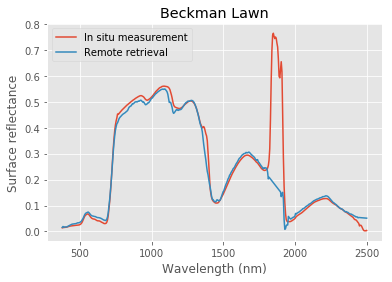

In [25]:
wl_insitu, rfl_insitu, fwhm = s.loadtxt('data/beckmanlawn_reflectance.txt').T

wavelengths = fm.surface.wl
rfl_insitu = interp1d(wl_insitu, rfl_insitu, bounds_error=False, fill_value='extrapolate')(fm.surface.wl)
plt.plot(wavelengths, rfl_insitu)
plt.plot(wavelengths, rfl_est)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.title('Beckman Lawn')
plt.legend(['In situ measurement','Remote retrieval']);

Note that there is a term we have set to zero in our instrument model - the "uncorrelated_radiometric_uncertainty" which is due mainly to effects like calibration errors.  

<b>Question:</b> Can we improve the match between the remote and in-situ reflectances by incorporating this source of uncertianty in our retrieval? What is its optimal value? How does it affect sensitivity to atmospheric parameters?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.